# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeClassifier

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

# Train and test data loading 

In [2]:
# loading from training file
train_df = pd.read_csv('../data/processed/train_data.csv')
X_train = train_df.iloc[:, 1:-1]
y_train = train_df['contraceptive_method']

# loading from test file
test_df = pd.read_csv('../data/processed/test_data.csv')
X_test = test_df.iloc[:, 1:-1]
y_test = test_df['contraceptive_method']


In [3]:
X_train.head()

,age,education,spouse_education,children,religion,work,spouse_occupation,living_standard,media_exposure
0,35,4,4,4,0,0,1,4,0
1,41,4,4,4,0,0,2,4,0
2,37,2,3,5,1,1,4,2,0
3,19,4,4,1,1,1,1,3,0
4,33,2,3,2,1,1,3,2,0


The class 1, in what follows next, will correspond to no contraception, class 2 to long term contraception and class 3 to short term contraception.

# Feature Encoding and preprocessing

In [4]:
numerical_feats = ['age', 'children'] 
categorical_feats = ['spouse_occupation']
binary_feats = ['religion', 'work', 'media_exposure']
pass_feats = ['education', 'spouse_education', 'living_standard'] # passthrough as already encoded

In [5]:
# making a column transforrmer for preprocessing

ct = make_column_transformer(
    (StandardScaler(), numerical_feats),  # scaling on numeric features
    ("passthrough", pass_feats),  # no transformations on the ordinal features
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features 
    ("passthrough", binary_feats)   # already encoded
)
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'children']),
                                ('passthrough-1', 'passthrough',
                                 ['education', 'spouse_education',
                                  'living_standard']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['spouse_occupation']),
                                ('passthrough-2', 'passthrough',
                                 ['religion', 'work', 'media_exposure'])])

In [6]:
# transform features
X_transformed = ct.fit_transform(X_train)

# get column names
column_names = (
    numerical_feats
    + pass_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
    + binary_feats
)

X_enc = pd.DataFrame(X_transformed, columns=column_names)

# encoded features
X_enc.head()

,age,children,education,spouse_education,living_standard,spouse_occupation_1,spouse_occupation_2,spouse_occupation_3,spouse_occupation_4,religion,work,media_exposure
0,0.295768,0.293880,4.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.017122,0.293880,4.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.536219,0.712490,2.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,-1.627844,-0.961951,4.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.055316,-0.543341,2.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


# Ridge classifier

In [7]:
# transformtion and classification pipeline
pipe_ridge = make_pipeline(ct, RidgeClassifier(random_state=123))

# fit pipeline
pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'children']),
                                                 ('passthrough-1',
                                                  'passthrough',
                                                  ['education',
                                                   'spouse_education',
                                                   'living_standard']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['spouse_occupation']),
                                                 ('passthrough-2',
                                                  'passthrough',
                                                  ['religion', 'work',
                                                   'media_exposure'])])),
                ('ridgeclassifier', RidgeClassifier(random_state=123))])

### Defining custom scoring metrics due to multiclass

In [8]:
# for class 1
def f1_1(true, pred):
    return f1_score(true, pred, average=None)[0]

# for class 2
def f1_2(true, pred):
    return f1_score(true, pred, average=None)[1]

# for class 3
def f1_3(true, pred):
    return f1_score(true, pred, average=None)[2]

# for class 4
def f1_avg(true, pred):
    return f1_score(true, pred, average='weighted')


scoring = {'f1_class1': make_scorer(f1_1),
          'f1_class2': make_scorer(f1_2),
          'f1_class3': make_scorer(f1_3),
          'f1_avg': make_scorer(f1_avg)}

### Cross validation results

In [9]:
# getting cross validation results
results = pd.DataFrame(cross_validate(pipe_ridge, X_train, y_train,
                                      return_train_score=True,
                                     scoring = scoring))
results

,fit_time,score_time,test_f1_class1,train_f1_class1,test_f1_class2,train_f1_class2,test_f1_class3,train_f1_class3,test_f1_avg,train_f1_avg
0,0.012857,0.016594,0.600000,0.607341,0.309524,0.358025,0.505618,0.450832,0.503203,0.498127
1,0.009635,0.007886,0.546256,0.613636,0.359551,0.389222,0.358974,0.480597,0.440045,0.518043
2,0.006988,0.006864,0.616740,0.608108,0.409091,0.376471,0.433121,0.448171,0.507187,0.501611
3,0.006983,0.006341,0.657658,0.610670,0.288889,0.433604,0.430380,0.421384,0.497719,0.505976
4,0.007008,0.006073,0.523810,0.625581,0.375000,0.384840,0.411111,0.503660,0.452036,0.530202


The f1 score for class 1 (No contraception) seems to be the highest and lowest for the class for long term contraception

In [10]:
class_names = ['class 1', 'class 2', 'class 3']
print(classification_report(y_train, pipe_ridge.predict(X_train), target_names=class_names))

              precision    recall  f1-score   support

     class 1       0.56      0.66      0.61       510
     class 2       0.49      0.30      0.38       260
     class 3       0.45      0.47      0.46       408

    accuracy                           0.51      1178
   macro avg       0.50      0.48      0.48      1178
weighted avg       0.51      0.51      0.51      1178



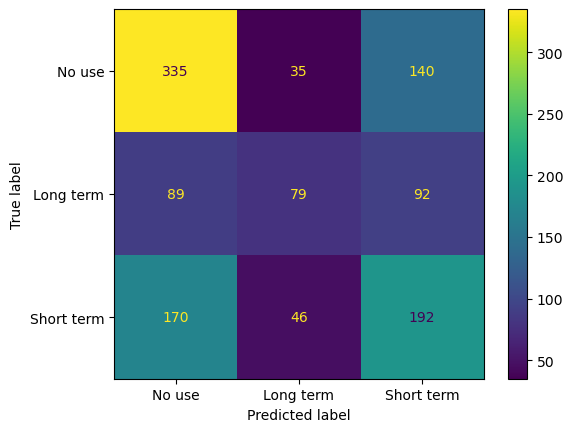

In [11]:
cm = ConfusionMatrixDisplay.from_estimator(
    pipe_ridge, X_train, y_train, values_format="d", display_labels=["No use", "Long term", "Short term"]
)

# Logistic Regression

In [12]:
# pipeline
pipe_log = make_pipeline(ct, LogisticRegression(max_iter=2000))

pipe_log.fit(X_train, y_train)

# cross validation
results = pd.DataFrame(cross_validate(pipe_log,
                                      X_train,
                                      y_train,
                                      return_train_score=True, 
                                      scoring=scoring))
results

,fit_time,score_time,test_f1_class1,train_f1_class1,test_f1_class2,train_f1_class2,test_f1_class3,train_f1_class3,test_f1_avg,train_f1_avg
0,0.048858,0.006080,0.591133,0.613455,0.395604,0.429799,0.516854,0.452888,0.522242,0.517335
1,0.042728,0.006357,0.561086,0.619159,0.383838,0.420455,0.342105,0.479290,0.445945,0.526879
2,0.048468,0.006524,0.616071,0.611111,0.422222,0.394521,0.430380,0.442748,0.508839,0.505021
3,0.045772,0.006262,0.651163,0.611628,0.304348,0.450928,0.453988,0.437596,0.506458,0.515834
4,0.049972,0.006301,0.517073,0.630202,0.441860,0.425068,0.424581,0.492625,0.468550,0.537248


### Getting feature coefficients for feature importances

In [13]:
# get  coefficients for all classes 
log_coefs = pd.DataFrame(
    data=pipe_log.named_steps["logisticregression"].coef_.transpose(), 
    index=column_names, 
    columns=["Coefficient_No_use", 'Coefficient_Long_term', 'Coefficient_short_term']
)
top_coeddicients = log_coefs.head(20)

top_coeddicients.to_csv("../results/analysis_results/feature_importances.csv")

top_coeddicients

,Coefficient_No_use,Coefficient_Long_term,Coefficient_short_term
age,0.401876,0.042228,-0.444104
children,-0.505651,0.251134,0.254517
education,-0.395890,0.416254,-0.020364
spouse_education,0.023291,-0.070860,0.047569
living_standard,-0.176806,0.124015,0.052791
spouse_occupation_1,-0.017344,0.191401,-0.174057
spouse_occupation_2,0.134484,-0.195039,0.060554
spouse_occupation_3,0.014885,-0.149108,0.134224
spouse_occupation_4,-0.145568,0.158568,-0.013000
religion,0.311725,-0.268589,-0.043136


We have three main observations here:
- `age` positively pushes the classification for class  1, and `children` has negative impact on the same. That is higher age will help with a prediction of no contraception, while more children will help predict for a user against no contraception. 
- both more`children` and more `education` push towards long term contraception
- `age` negatively impacts short term contraception and `children` positively impact it.

In [14]:
class_names = ['class 1', 'class 2', 'class 3']
print(classification_report(y_train, pipe_log.predict(X_train), target_names=class_names))

              precision    recall  f1-score   support

     class 1       0.59      0.64      0.61       510
     class 2       0.50      0.37      0.43       260
     class 3       0.45      0.46      0.45       408

    accuracy                           0.52      1178
   macro avg       0.51      0.49      0.50      1178
weighted avg       0.52      0.52      0.52      1178



The scores still don't look too promising, but can pass for a multiclass problem

# SVC

In [15]:
pipe_svc = make_pipeline(ct, SVC(gamma=0.1))

pipe_svc.fit(X_train, y_train)

results = pd.DataFrame(cross_validate(pipe_svc,
                                      X_train, 
                                      y_train, 
                                      return_train_score=True,
                                     scoring=scoring))
results

,fit_time,score_time,test_f1_class1,train_f1_class1,test_f1_class2,train_f1_class2,test_f1_class3,train_f1_class3,test_f1_avg,train_f1_avg
0,0.046504,0.026421,0.625592,0.696366,0.474227,0.436658,0.500000,0.584848,0.548603,0.600427
1,0.044402,0.026720,0.595960,0.716200,0.400000,0.473829,0.525140,0.602857,0.528175,0.623458
2,0.045641,0.026200,0.711111,0.684770,0.484211,0.454054,0.539474,0.575712,0.601479,0.596084
3,0.045356,0.026275,0.656863,0.692118,0.382022,0.474934,0.564972,0.587050,0.564374,0.607779
4,0.042659,0.026049,0.614583,0.699629,0.444444,0.466844,0.500000,0.608571,0.537441,0.616707


In [16]:
class_names = ['class 1', 'class 2', 'class 3']
print(classification_report(y_train, pipe_svc.predict(X_train), target_names=class_names))

              precision    recall  f1-score   support

     class 1       0.69      0.70      0.69       510
     class 2       0.53      0.42      0.46       260
     class 3       0.56      0.62      0.59       408

    accuracy                           0.61      1178
   macro avg       0.59      0.58      0.58      1178
weighted avg       0.61      0.61      0.61      1178



The scores seem to have improved with the SVC classifier.

# Random forest

In [17]:
pipe_rf = make_pipeline(ct, RandomForestClassifier(max_depth=4, n_estimators=1000))

pipe_rf.fit(X_train, y_train)

results = pd.DataFrame(cross_validate(pipe_rf, 
                                      X_train,
                                      y_train,
                                      return_train_score=True,
                                     scoring=scoring))
results

,fit_time,score_time,test_f1_class1,train_f1_class1,test_f1_class2,train_f1_class2,test_f1_class3,train_f1_class3,test_f1_avg,train_f1_avg
0,1.064938,0.091474,0.603960,0.710059,0.452381,0.382716,0.505376,0.593007,0.536308,0.597271
1,1.086420,0.090238,0.644860,0.697460,0.404762,0.405063,0.505747,0.561254,0.543621,0.585759
2,1.054458,0.090151,0.681223,0.690952,0.363636,0.386503,0.542169,0.568600,0.562931,0.581385
3,1.054100,0.091933,0.676056,0.694611,0.250000,0.437500,0.531073,0.563662,0.531807,0.592491
4,1.083073,0.090373,0.582915,0.687728,0.390244,0.408284,0.486772,0.573793,0.507143,0.586582


In [18]:
class_names = ['class 1', 'class 2', 'class 3']
print(classification_report(y_train, pipe_rf.predict(X_train), target_names=class_names))

              precision    recall  f1-score   support

     class 1       0.66      0.70      0.68       510
     class 2       0.53      0.31      0.39       260
     class 3       0.51      0.62      0.56       408

    accuracy                           0.59      1178
   macro avg       0.57      0.54      0.54      1178
weighted avg       0.58      0.59      0.58      1178



# Gradient Boosting

In [19]:
pipe_gb = make_pipeline(ct, GradientBoostingClassifier())

pipe_gb.fit(X_train, y_train)

results = pd.DataFrame(cross_validate(pipe_gb, 
                                      X_train,
                                      y_train, 
                                      return_train_score=True,
                                     scoring=scoring))
results

,fit_time,score_time,test_f1_class1,train_f1_class1,test_f1_class2,train_f1_class2,test_f1_class3,train_f1_class3,test_f1_avg,train_f1_avg
0,0.297400,0.007877,0.603960,0.777086,0.469388,0.581333,0.476744,0.682720,0.530107,0.701205
1,0.334976,0.010514,0.594872,0.767500,0.408163,0.582011,0.435754,0.660057,0.498446,0.689360
2,0.314960,0.007491,0.676329,0.762148,0.382979,0.631841,0.514620,0.680000,0.555505,0.704946
3,0.294770,0.007675,0.676617,0.750948,0.359551,0.624672,0.588889,0.669468,0.576219,0.694840
4,0.299187,0.007687,0.589474,0.759690,0.420000,0.635236,0.488889,0.679831,0.517303,0.704546


In [20]:
class_names = ['class 1', 'class 2', 'class 3']
print(classification_report(y_train, pipe_gb.predict(X_train), target_names=class_names))

              precision    recall  f1-score   support

     class 1       0.76      0.71      0.74       510
     class 2       0.62      0.54      0.58       260
     class 3       0.60      0.70      0.65       408

    accuracy                           0.67      1178
   macro avg       0.66      0.65      0.65      1178
weighted avg       0.68      0.67      0.67      1178



# Hyperparameter tuning with SVC

In [21]:
# set. up a parameter grid
param_grid = {
    "svc__gamma": np.logspace(-3, 3, 20),
    "svc__C": np.linspace(2, 3, 100),
}

random_search = RandomizedSearchCV(
    pipe_svc,
    param_distributions=param_grid,
    n_jobs=-1, 
    n_iter=20,
    cv=5, 
    random_state=42,
    scoring=scoring,
    refit='f1_avg'
)
random_search.fit(X_train, y_train);

In [22]:
random_search.best_params_

{'svc__gamma': 0.07847599703514611, 'svc__C': 2.5656565656565657}

In [23]:
pd.DataFrame(random_search.cv_results_)[
    [
        "param_svc__gamma",
        "param_svc__C",
        "mean_test_f1_avg",
        "rank_test_f1_avg",
    ]
].set_index("rank_test_f1_avg").sort_index().T

rank_test_f1_avg,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,17,17,20
param_svc__gamma,0.078476,0.078476,0.162378,0.162378,0.01833,0.01833,0.008859,0.004281,1.43845,1.43845,1.43845,2.976351,0.002069,26.366509,54.555948,112.883789,483.293024,1000.0,483.293024,0.001
param_svc__C,2.565657,2.232323,2.848485,2.040404,2.868687,2.525253,2.565657,2.747475,2.161616,2.060606,2.565657,2.434343,2.060606,2.646465,2.545455,2.69697,2.616162,2.727273,2.818182,2.434343
mean_test_f1_avg,0.551502,0.550922,0.548253,0.546526,0.543708,0.542579,0.52527,0.504611,0.48626,0.485409,0.483772,0.468969,0.353883,0.353555,0.341954,0.323864,0.300208,0.300208,0.300208,0.278746


# Logistic Regression with polynomial features

In [24]:
# adding polynomial featuures of degree 2 to check if scores improve
pipe_log_poly = make_pipeline(ct, 
                              PolynomialFeatures(degree=2),
                              LogisticRegression(max_iter=2000))

pipe_log_poly.fit(X_train, y_train)

results = pd.DataFrame(cross_validate(pipe_log_poly, X_train, y_train, return_train_score=True, scoring=scoring))
results

,fit_time,score_time,test_f1_class1,train_f1_class1,test_f1_class2,train_f1_class2,test_f1_class3,train_f1_class3,test_f1_avg,train_f1_avg
0,0.816583,0.011401,0.625000,0.691477,0.403846,0.507853,0.450000,0.606876,0.515466,0.621653
1,0.609677,0.006451,0.584158,0.706456,0.438095,0.546392,0.484848,0.613333,0.517469,0.638885
2,0.590009,0.006530,0.679245,0.669915,0.363636,0.506329,0.534161,0.574850,0.559294,0.600895
3,0.804651,0.006949,0.657407,0.686820,0.387097,0.505102,0.559006,0.596702,0.563677,0.615488
4,0.679829,0.007255,0.588832,0.694377,0.446809,0.489899,0.491620,0.598214,0.523899,0.615929


In [25]:
#. hyperparameter tuning

param_grid = {
    "logisticregression__C": np.linspace(0.5, 3, 1000),
    "logisticregression__max_iter": np.linspace(1000, 10000, 100),
}

random_search = RandomizedSearchCV(
    pipe_log_poly, param_distributions=param_grid, n_jobs=-1, n_iter=20, cv=5, random_state=42, scoring=scoring, refit='f1_avg'
)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['age',
                                                                                'children']),
                                                                              ('passthrough-1',
                                                                               'passthrough',
                                                                               ['education',
                                                                                'spouse_education',
                                                                                'living_standard']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['spouse_occupation']),
                                                                              ('passthrough-2',
                                                                               'passthrough',
                                                                               ['religion',
                                                                                'work',
                                                                                'me...
        8636.36363636,  8727.27272727,  8818.18181818,  8909.09090909,
        9000.        ,  9090.90909091,  9181.81818182,  9272.72727273,
        9363.63636364,  9454.54545455,  9545.45454545,  9636.36363636,
        9727.27272727,  9818.18181818,  9909.09090909, 10000.        ])},
                   random_state=42, refit='f1_avg',
                   scoring={'f1_avg': make_scorer(f1_avg),
                            'f1_class1': make_scorer(f1_1),
                            'f1_class2': make_scorer(f1_2),
                            'f1_class3': make_scorer(f1_3)})

In [26]:
random_search.best_params_

{'logisticregression__max_iter': 6454.545454545454,
 'logisticregression__C': 0.52002002002002}

In [27]:
pd.DataFrame(random_search.cv_results_)[
    [
        "param_logisticregression__C",
        "param_logisticregression__max_iter",
        "mean_test_f1_avg",
        "rank_test_f1_avg",
    ]
].set_index("rank_test_f1_avg").sort_index().T

rank_test_f1_avg,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,17,19,20
param_logisticregression__C,0.52002,0.517518,2.006507,1.993994,2.074074,2.421922,2.121622,0.655155,2.181682,2.199199,2.124124,1.526026,1.428428,0.632633,1.871371,1.603604,2.687187,2.55956,0.892893,0.9004
param_logisticregression__max_iter,6454.545455,7272.727273,6727.272727,4181.818182,6000.0,2818.181818,2818.181818,6909.090909,2909.090909,7272.727273,3272.727273,9181.818182,9545.454545,2000.0,8818.181818,3818.181818,9909.090909,8818.181818,9636.363636,3090.909091
mean_test_f1_avg,0.5407,0.540481,0.539961,0.538403,0.538334,0.53828,0.538278,0.537989,0.537575,0.53757,0.537513,0.537334,0.537254,0.537209,0.536582,0.536531,0.536444,0.536444,0.535838,0.534911


In [28]:
confusion_matrix(y_train, cross_val_predict(random_search.best_estimator_, X_train, y_train))

array([[327,  55, 128],
       [ 79, 100,  81],
       [119,  76, 213]])

In [29]:
#classiification report. on training data

class_names = ['class 1', 'class 2', 'class 3']
print(classification_report(y_train, random_search.best_estimator_.predict(X_train), target_names=class_names))

              precision    recall  f1-score   support

     class 1       0.68      0.69      0.68       510
     class 2       0.51      0.45      0.48       260
     class 3       0.57      0.60      0.58       408

    accuracy                           0.61      1178
   macro avg       0.59      0.58      0.58      1178
weighted avg       0.60      0.61      0.60      1178



# Checking on Test data

We use the model which incorporates polynomial features and is hyperparameter tuned as well to test our model on the testing data. Here we use the pipeline with logistic regression and hy

In [30]:
class_names = ['class 1', 'class 2', 'class 3']
print(classification_report(y_test, random_search.best_estimator_.predict(X_test), target_names=class_names))

              precision    recall  f1-score   support

     class 1       0.58      0.75      0.65       119
     class 2       0.47      0.37      0.41        73
     class 3       0.56      0.46      0.50       103

    accuracy                           0.55       295
   macro avg       0.54      0.52      0.52       295
weighted avg       0.55      0.55      0.54       295



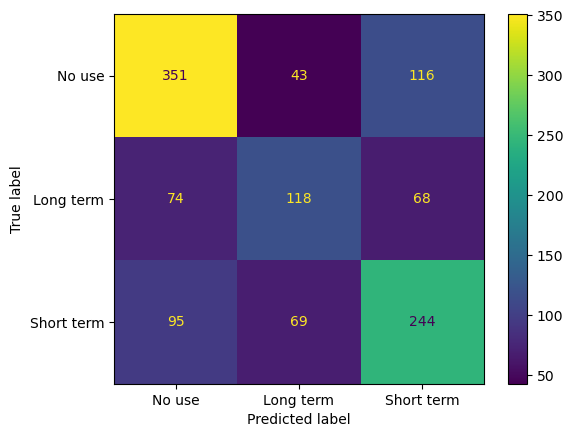

In [31]:
cm = ConfusionMatrixDisplay.from_estimator(
    random_search.best_estimator_, X_train, y_train, values_format="d", display_labels=["No use", "Long term", "Short term"]
)

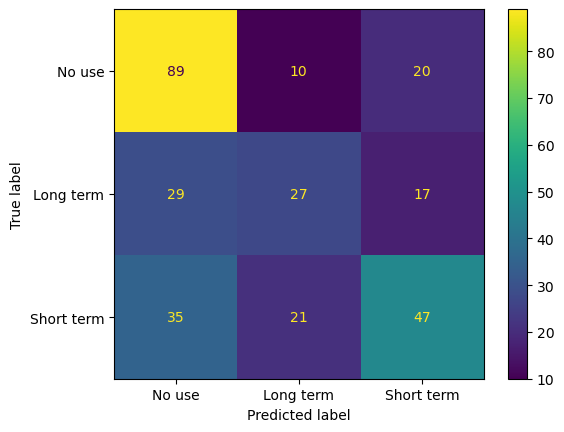

In [32]:
cm = ConfusionMatrixDisplay.from_estimator(
    random_search.best_estimator_, X_test, y_test, values_format="d", display_labels=["No use", "Long term", "Short term"]
)